In [1]:
import os 
import numpy as np
from PIL import Image
from scipy.ndimage.filters import gaussian_filter
from scipy import ndimage
from google.cloud import storage
from io import BytesIO
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

In [2]:
client = storage.Client()
bucket = client.get_bucket("amnh-condenast")

In [3]:
def load_image(k):
    k_str = str(k)
    while len(k_str) < 4:
        k_str = "0" + k_str
    file_name = "Sem2_YZ_8a/Sem2_YZ_8a_{}.tif".format(k_str)
    try:
        blob = bucket.get_blob(file_name)
        content = blob.download_as_string()
        buf = BytesIO()
        buf.write(content)
        buf.seek(0)
        im = Image.open(buf)
        return im
    except:
        print(file_name)

In [73]:
def save_image(image, folder_name, k):
    k_str = str(k)
    while len(k_str) < 4:
        k_str = "0" + k_str
    file_name = "processed_{}/Sem2_YZ_8a_{}.png".format(folder_name, k_str)
    blob = bucket.blob(file_name)
    buf = BytesIO()
    image.save(buf, "PNG")
    buf.seek(0)
    s = buf.read()
    blob.upload_from_string(s)
    return True

In [134]:
def save_image_named(image, name):
    file_name = "{}.png".format(name)
    blob = bucket.blob(file_name)
    buf = BytesIO()
    image.save(buf, "PNG")
    buf.seek(0)
    s = buf.read()
    blob.upload_from_string(s)


In [4]:
im_3d = np.array([np.array(load_image(k)) for k in range(650)])

In [17]:
im_3d.shape

(650, 1347, 589)

In [ ]:
def to_gradient_norm(im_3d):
    t = im_3d.astype(float)/256
    temp = np.gradient(t)
    temp2 = np.stack(temp, axis=3)
    temp3 = np.linalg.norm(temp2, axis=3) * 256
    return temp3

In [ ]:
def thresh(x, thr):
    if x > thr:
        return x
    else: return 0
    
thresh_vec = np.vectorize(thresh)

In [ ]:
def promote_edges(im_3d, blur, contrast, drop_off):
    blurred = (gaussian_filter(im_3d, blur) * contrast).astype(np.dtype("uint8"))
    return thresh_vec(blurred, drop_off * 256)

In [28]:
def remove_low_density(array, blur, threshold):
    mask = gaussian_filter(array, blur)
    array_copy =  np.copy(array)
    array_copy[mask < threshold*256] = 0
    return array_copy

In [35]:
def reinforce_high_density(array, blur, threshold):
    mask = gaussian_filter(array, blur)
    array_copy =  np.copy(array)
    array_copy[mask > threshold*256] = 255
    return array_copy

In [ ]:
normed = to_gradient_norm(im_3d)

In [ ]:
edges = promote_edges(normed, .5, 8, .4)

In [ ]:
super_edges = promote_edges(edges, 3, 8, .6)

In [29]:
clean_edges = remove_low_density(edges, 2, .4)

In [ ]:
thing = ((im_3d * .15)+((clean_edges)>30).astype(np.dtype("uint8"))*255  * .65 
         + (super_edges * .2)).astype(np.dtype("uint8"))
thing_copy = np.copy(thing)
thing_copy = 255-thing_copy
thing_copy[im_3d<50] = 0
put_out = remove_low_density(thing_copy, 2, .4)

In [ ]:
im_3d_copy = np.copy(im_3d)

In [ ]:
im_3d_copy[im_3d_copy < 50] = 255

In [75]:
grad_filled = (im_3d*.5 + reinforce_high_density(thing, 2, .4)*.5).astype(np.dtype("uint8"))

In [76]:
for k in range(650):
    save_image(Image.fromarray(grad_filled[k]), "grad_filled", k)

In [148]:
index = 171

In [149]:
initial = Image.fromarray(im_3d[index])

In [150]:
contours = Image.fromarray(normed[index].astype(np.dtype("uint8"))*8)

In [151]:
clean = Image.fromarray(edges[index].astype(np.dtype("uint8")))

In [152]:
extreme = Image.fromarray(clean_edges[index].astype(np.dtype("uint8")))

In [153]:
level_curves_rough = Image.fromarray(super_edges[index].astype(np.dtype("uint8")))

In [154]:
mostly_overlays = Image.fromarray((reinforce_high_density(thing[index], 2, .4)*2).astype(np.dtype("uint8")))

In [155]:
preprocessed = Image.fromarray(grad_filled[index])

In [ ]:
thing = ((im_3d * .15)+((clean_edges)>30).astype(np.dtype("uint8"))*255  * .65 + (super_edges * .2)).astype(np.dtype("uint8"))
thing_copy = np.copy(thing)
thing_copy = 255-thing_copy
thing_copy[im_3d<50] = 0
put_out = remove_low_density(thing_copy, 2, .82)

In [156]:
almost_solved_no_algorithm = Image.fromarray(condrils_rough[index])

In [157]:
save_image_named(initial, "assets/examples/slice_{}/initial".format(index))

In [158]:
save_image_named(contours, "assets/examples/slice_{}/contours".format(index))

In [159]:
save_image_named(clean, "assets/examples/slice_{}/clean".format(index))

In [160]:
save_image_named(extreme, "assets/examples/slice_{}/extreme".format(index))

In [161]:
save_image_named(level_curves_rough, "assets/examples/slice_{}/level_curves_rough".format(index))

In [162]:
save_image_named(mostly_overlays, "assets/examples/slice_{}/mostly_overlays".format(index))

In [163]:
save_image_named(preprocessed, "assets/examples/slice_{}/preprocessed".format(index))

In [164]:
save_image_named(almost_solved_no_algorithm, "assets/examples/slice_{}/almost_solved_no_algorithm".format(index))

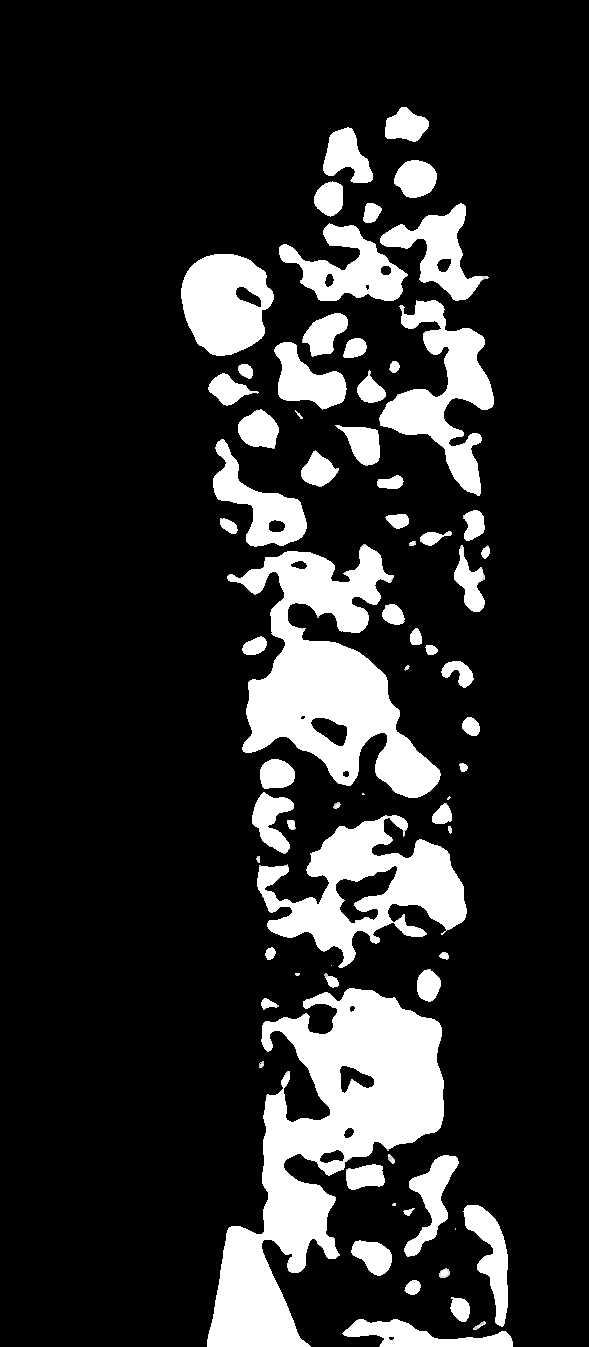

In [132]:
almost_solved_no_algorithm

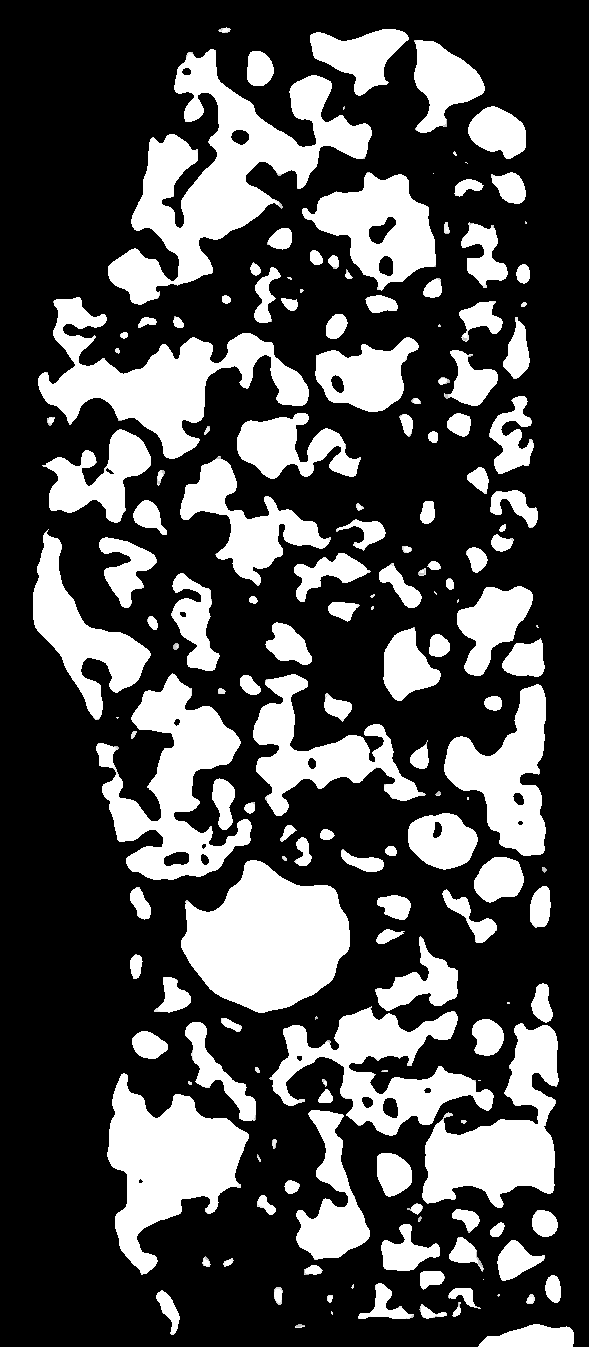

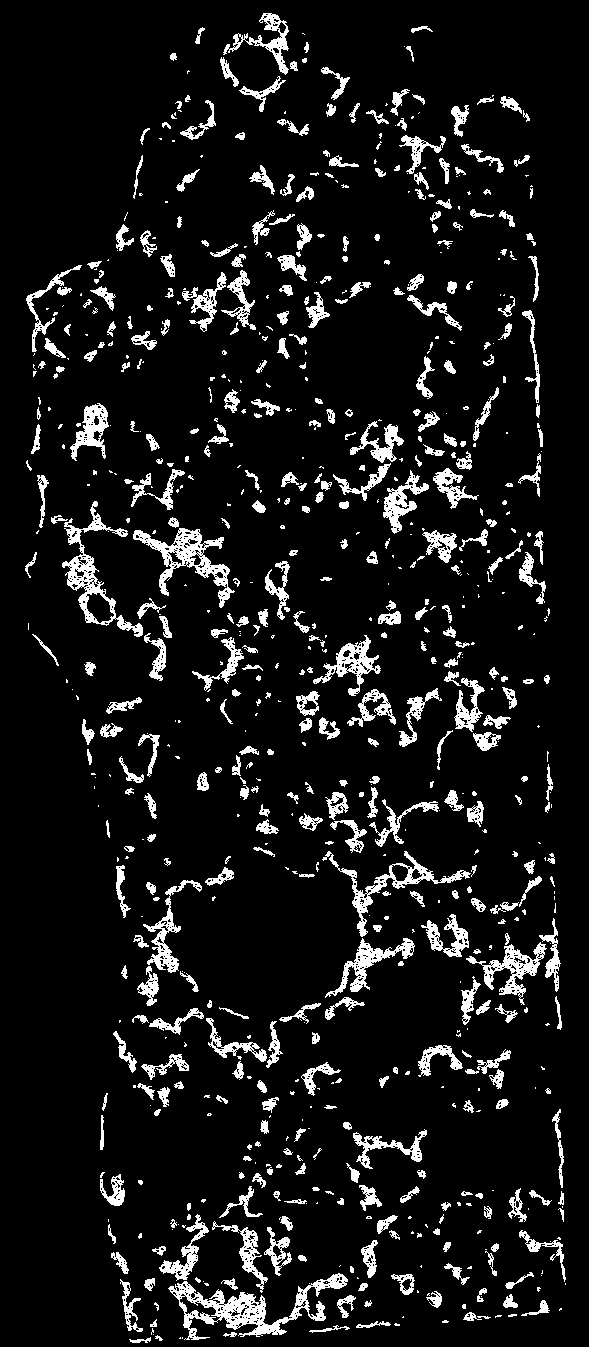

In [85]:
Image.fromarray((((clean_edges)>30).astype(np.dtype("uint8"))*255)[222].astype(np.dtype("uint8")))

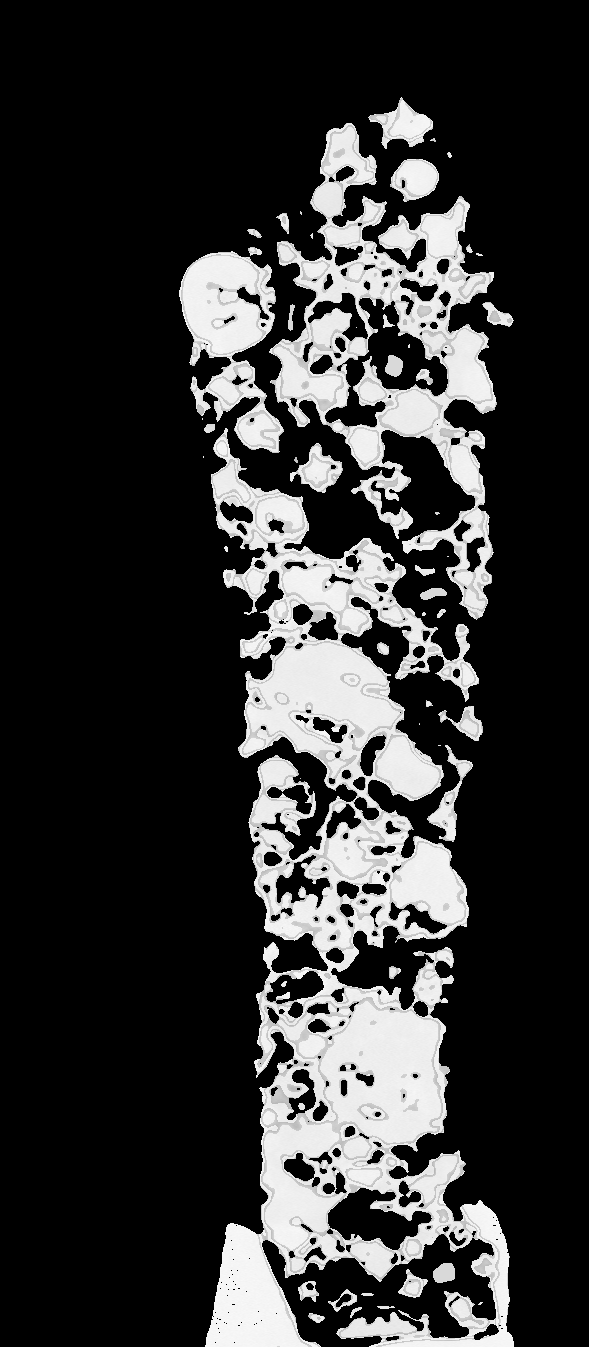

In [58]:
Image.fromarray(put_out[400].astype(np.dtype("uint8")))

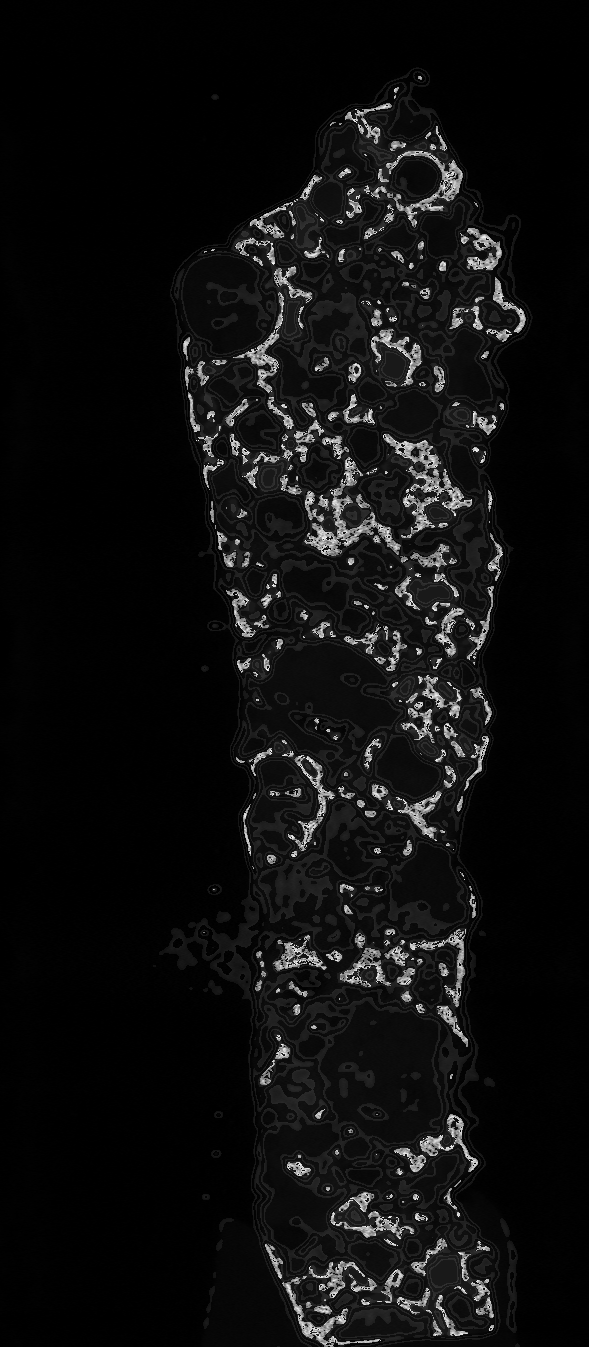

In [103]:
index = 400
Image.fromarray(((im_3d[index] * .1)+(clean_edges[index] * .8) + (super_edges[index] * .1)).astype(np.dtype("uint8")))

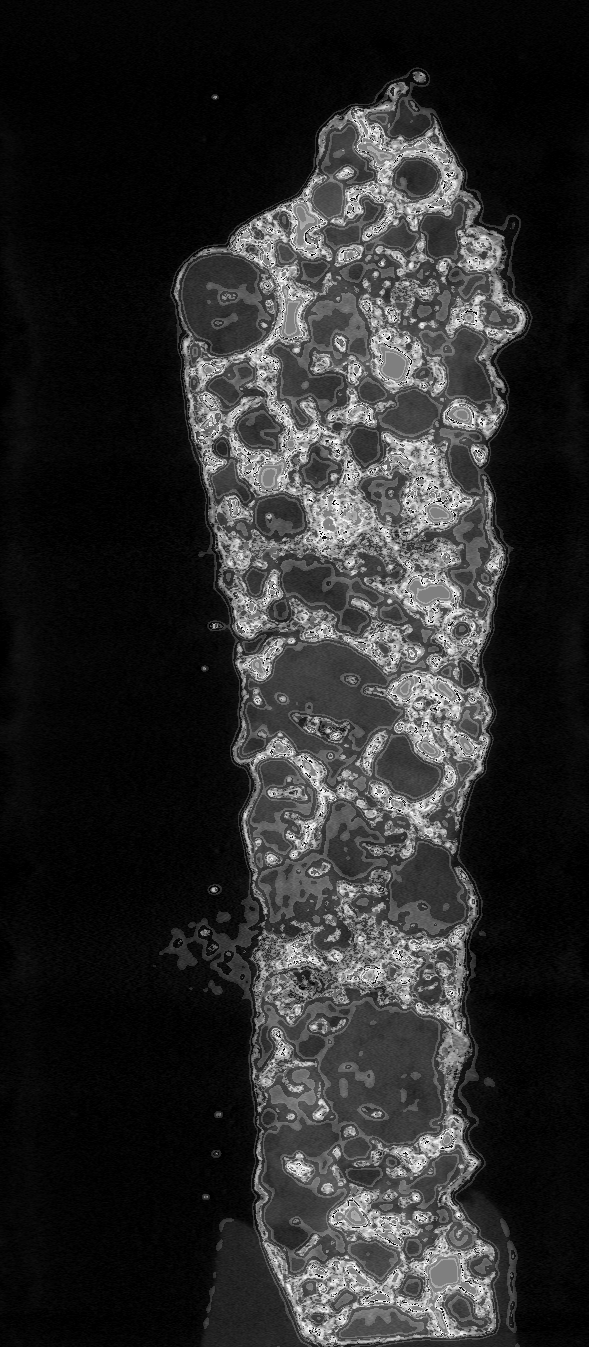

In [297]:
for_paul_bonus